In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

import statsmodels.api as sm

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

import seaborn as sns
from scipy import stats
from scipy.stats import truncnorm
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

import warnings
import os
from copy import deepcopy

import plotting
import dataset_fctns
import modelling_fctns

from  pydynpd import regression

In [2]:
def make_cumulative(ds, driver_variable = 'tas', numdays = 200, T_base = 0):
    ds.loc[:, [f'{driver_variable} at day {n}' for n in range(numdays)]] = (np.maximum(ds.loc[:, [f'{driver_variable} at day {n}' for n in range(numdays)]] - T_base, 0)).cumsum(axis = 1)
    return ds

Get an indexing column and time indexing column.

In [3]:
def get_progressions_from_data(srs, temp_variable = 't2m', NDVI_skip = 56, numsteps = 183):
    return np.array([[srs['year'], srs['Stations_id'], n, srs[f'NDVI interpolated at day {NDVI_skip + n}'], srs[f'{temp_variable} at day {n}'], srs[f'photoperiod at day {NDVI_skip + n}'], srs[f'dev stage at day {n}']] for n in range(numsteps)])

In [4]:
def convert_data_to_panel(ds, temp_variable = 't2m', NDVI_skip = 56, numsteps = 183):
    for point_index in range(len(ds)):
        arr_point = get_progressions_from_data(ds.iloc[point_index], temp_variable=temp_variable, NDVI_skip = NDVI_skip, numsteps = numsteps)
        ds_point = pd.DataFrame(arr_point, columns=['year', 'Stations_id', 'time from SOS', 'NDVI', 'acc temp', 'photoperiod', 'dev stage'])
        if point_index == 0:
            ds_panel = ds_point
        else:
            ds_panel = pd.concat([ds_panel, ds_point])
    return ds_panel

In [5]:
def logit_reg(train, predictors = ['NDVI', 'acc temp', 'photoperiod', 'const']):
    Xtrain = train[predictors] #'NDVI', 
    ytrain = train[['dev stage']]
    
    # building the model and fitting the data
    log_reg = sm.Logit(ytrain, Xtrain).fit()
    return log_reg

In [6]:
def train_test_on_statyear(ds, train_proportion = 0.8):
    statyear = ds[['Stations_id', 'year']].drop_duplicates().values
    train_size = int(statyear.shape[0]*train_proportion)
    test_size = statyear.shape[0] - train_size
    row_choices = np.random.choice(np.arange(statyear.shape[0]), size = train_size, replace = False)
    train_statyear = pd.DataFrame(statyear[row_choices, :], columns = ['Stations_id', 'year'])
    test_statyear = pd.DataFrame(np.delete(statyear, row_choices, axis = 0), columns = ['Stations_id', 'year'])
    train = ds.merge(train_statyear, on=['Stations_id', 'year'], how = 'inner') #.loc[ds[['Stations_id', 'year']].isin(train_statyear)]
    test = ds.merge(test_statyear, on=['Stations_id', 'year'], how = 'inner')
    return train, test


In [7]:
def anthesis_from_ds(ds, obs_column):
    return ds.loc[ds[obs_column] == 1]['time from SOS'].min()

In [8]:
def compare_logreg_test(test, log_reg, predictors = ['NDVI', 'acc temp', 'photoperiod', 'const']):
    Xtest = test[predictors] #
    ytest = test[['dev stage']]
    with warnings.catch_warnings(action="ignore"):
        Xtest.loc[:, 'fitted'] = log_reg.predict(Xtest).round()
        Xtest.loc[:, 'observed'] = ytest
    test = test.merge(Xtest[['fitted', 'observed']], left_index=True, right_index=True)
    test_observed = test.groupby(['Stations_id', 'year']).apply(anthesis_from_ds, 'observed', include_groups = False)
    test_fitted = test.groupby(['Stations_id', 'year']).apply(anthesis_from_ds, 'fitted', include_groups = False)
    test_for_regression = pd.concat([test_fitted, test_observed], axis=1).rename(columns = {0: 'fitted', 1: 'observed'})
    return test_for_regression#, test

In [9]:
def plot_fitted_observed_histogram(test_for_regression, title = 'fitted vs. observed'):
    fig, ax = plt.subplots()
    sns.histplot(x='fitted', data = test_for_regression, ax=ax, label = 'fitted',
                stat = 'density')
    sns.histplot(x='observed', data = test_for_regression, ax=ax, label= 'observed',
                stat = 'density')
    ax.set_xlabel('Days to anthesis')
    ax.set_title(title)
    #ax.plot([minval, maxval], [minval, maxval], linestyle = '--', color='k')
    fig.legend(bbox_to_anchor = (1.2, 0.9))
    rsquared = r2_score(comparison_frame['observed'], comparison_frame['fitted'])
    print(f'R^2 value for model: {rsquared}')
    bias = comparison_frame['observed'].mean() - comparison_frame['fitted'].mean()
    variance_modelled = comparison_frame[f'fitted'].var()
    print(f'Bias: {bias**2}\nVariance of modelled values: {variance_modelled}')

In [10]:
def plot_fitted_observed(test_for_regression, title = 'fitted vs observed'):
    fig, ax = plt.subplots()
    minval = test_for_regression['fitted'].min()
    maxval = test_for_regression['observed'].max()
    sns.regplot(data = test_for_regression, x = 'fitted', y ='observed', ax = ax, 
                scatter_kws={'alpha':0.5, 's':4},  x_bins=np.arange(minval - 5, maxval + 5, 3))
    ax.plot([minval, maxval], [minval, maxval], linestyle = '--', color = 'black')
    r2_score_model = r2_score(test_for_regression['observed'], test_for_regression['fitted'])
    print('R2 score', r2_score_model)
    ax.set_title(title)

In [31]:
def KFold_crossval(ds, k_folds, predictors = ['NDVI', 'acc temp', 'photoperiod', 'const']):
    kf = KFold(n_splits=k_folds, shuffle=True, random_state = 1)
    loss_values = []
    R2s = []
    Biases = []
    Variances = []

    statyear = ds[['Stations_id', 'year']].drop_duplicates()

    for fold, (train_idx, test_idx) in enumerate(kf.split(statyear)):
        train_statyear = statyear.iloc[train_idx]
        test_statyear = statyear.iloc[test_idx]
        train = ds.merge(train_statyear, on=['Stations_id', 'year'], how = 'inner') #.loc[ds[['Stations_id', 'year']].isin(train_statyear)]
        test = ds.merge(test_statyear, on=['Stations_id', 'year'], how = 'inner')
        print(len(test))

        log_reg = logit_reg(train, predictors=predictors)
        test_for_regression = compare_logreg_test(test, log_reg, predictors=predictors)

        r2_score_model = r2_score(test_for_regression['observed'], test_for_regression['fitted'])
        bias_model = (test_for_regression['observed'] - test_for_regression['fitted']).mean()**2
        variance = test_for_regression['fitted'].var()

        R2s.append(r2_score_model)
        Biases.append(bias_model)
        Variances.append(variance)

        print(f'Fold: {fold + 1}\nR2: {r2_score_model}\nBias: {bias_model}\nVariance: {variance}')
    print(f'Average score: {np.mean(R2s)}')
    return R2s, Biases, Variances

In [68]:
ds_inputs_SSA['observed time to beginning of flowering'].min()

49

In [12]:
ds_inputs_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_with_mask_PD_SOS.csv')
#ds_inputs_DE.loc[:, [f'temperature at day {n}' for n in range(200)]] = modelling_fctns.Wang_Engel_Temp_response(ds_inputs_DE.loc[:, [f'temperature at day {n}' for n in range(200)]], 7, 28, 42)
ds_inputs_DE = make_cumulative(ds_inputs_DE, driver_variable = 'temperature', numdays = 200, T_base = 0)


In [13]:
ds_inputs_SSA = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\SSA_ML_fixed_photoperiod.csv')
#ds_inputs_SSA.loc[:, [f'temperature at day {n}' for n in range(300)]] = modelling_fctns.Wang_Engel_Temp_response(ds_inputs_SSA.loc[:, [f'temperature at day {n}' for n in range(300)]], 7, 28, 42)
ds_inputs_SSA = make_cumulative(ds_inputs_SSA, driver_variable = 'temperature', numdays = 300, T_base = 0)


In [14]:
ds_panel_DE = convert_data_to_panel(ds_inputs_DE.dropna(how='any'), temp_variable = 'temperature', NDVI_skip=0, numsteps = 160)
ds_panel_SSA = convert_data_to_panel(ds_inputs_SSA, temp_variable = 'temperature', NDVI_skip=0, numsteps = 160)

In [15]:
ds_panel_DE.loc[:, 'const'] = 1
ds_panel_SSA.loc[:, 'const'] = 1

<Axes: xlabel='observed time to beginning of flowering', ylabel='Count'>

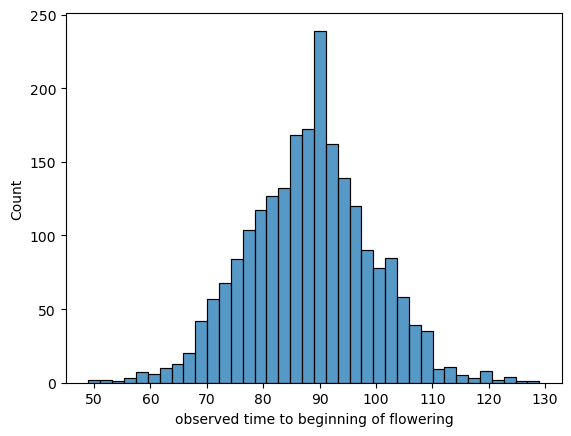

In [19]:
ds_inputs_DE['observed time to beginning of flowering']

In [92]:
ds_inputs_DE_mask = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_with_mask.csv')
ds_inputs_DE_mask.loc[:, [f't2m at day {n}' for n in range(200)]] = modelling_fctns.Wang_Engel_Temp_response(ds_inputs_DE_mask.loc[:, [f't2m at day {n}' for n in range(200)]], 7, 28, 42)
ds_inputs_DE_mask = make_cumulative(ds_inputs_DE_mask, driver_variable = 't2m', numdays = 200, T_base = 0)

ds_panel_DE_mask = convert_data_to_panel(ds_inputs_DE_mask)

ds_panel_DE_mask.loc[:, 'const'] = 1

In [32]:
R2s, Biases, Variances = KFold_crossval(ds_panel_DE, 5, predictors = ['NDVI', 'acc temp', 'photoperiod', 'time from SOS', 'const'])#.loc[(ds_panel_DE['year'] > 2000)*(ds_panel_DE['year'] < 2005)]'NDVI', 'acc temp', 'photoperiod', 'const'

70560
Optimization terminated successfully.
         Current function value: 0.083697
         Iterations 11
Fold: 1
R2: 0.5200139796241595
Bias: 0.17031997984378935
Variance: 64.33033395176263
70560
Optimization terminated successfully.
         Current function value: 0.083142
         Iterations 11
Fold: 2
R2: 0.5154371208611335
Bias: 1.059825895588772
Variance: 62.87737579880434
70560
Optimization terminated successfully.
         Current function value: 0.083945
         Iterations 11
Fold: 3
R2: 0.5375182023691034
Bias: 0.00018510805682817342
Variance: 61.92694289837168
70400
Optimization terminated successfully.
         Current function value: 0.084253
         Iterations 11
Fold: 4
R2: 0.5381709132177321
Bias: 0.9954597107438016
Variance: 63.50361876164836
70400
Optimization terminated successfully.
         Current function value: 0.085554
         Iterations 11
Fold: 5
R2: 0.5780443924398078
Bias: 0.06712809917355372
Variance: 60.064190308552476
Average score: 0.537836921702

In [46]:
np.mean(Biases)

0.458583758681349

In [37]:
R2s_nosat, Biases_nosat, Variances_nosat = KFold_crossval(ds_panel_SSA, 5, predictors = ['NDVI', 'photoperiod', 'acc temp', 'const'])

7360
Optimization terminated successfully.
         Current function value: 0.100019
         Iterations 10
Fold: 1
R2: 0.41171118976707965
Bias: 0.2084120982986767
Variance: 100.18599033816425
7360
Optimization terminated successfully.
         Current function value: 0.099982
         Iterations 10
Fold: 2
R2: 0.3284629558790806
Bias: 0.00047258979206049145
Variance: 114.0
7360
Optimization terminated successfully.
         Current function value: 0.111238
         Iterations 10
Fold: 3
R2: 0.5989043511628003
Bias: 0.12098298676748581
Variance: 94.49903381642511
7200
Optimization terminated successfully.
         Current function value: 0.107972
         Iterations 10
Fold: 4
R2: 0.3158930696695048
Bias: 0.8301234567901234
Variance: 85.24040404040403
7200
Optimization terminated successfully.
         Current function value: 0.108637
         Iterations 10
Fold: 5
R2: 0.5001797268152408
Bias: 0.02419753086419753
Variance: 88.9070707070707
Average score: 0.43103025865874117


In [43]:
np.mean(Biases_nosat)

0.23683773250250878

In [52]:
train, test = train_test_on_statyear(ds_panel_SSA, train_proportion = 0.98)
log_reg = logit_reg(train, predictors = ['NDVI', 'acc temp', 'photoperiod', 'time from SOS', 'const'])
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.104192
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:              dev stage   No. Observations:                35680
Model:                          Logit   Df Residuals:                    35675
Method:                           MLE   Df Model:                            4
Date:                Mon, 09 Jun 2025   Pseudo R-squ.:                  0.8494
Time:                        09:52:27   Log-Likelihood:                -3717.6
converged:                       True   LL-Null:                       -24687.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
NDVI              2.4763      0.284      8.724      0.000       1.920       3.033
acc temp          0

In [57]:
test_for_regression = compare_logreg_test(ds_panel_DE.reset_index(), log_reg, predictors = ['NDVI', 'acc temp', 'photoperiod', 'time from SOS', 'const'])
#test_for_regression = compare_logreg_test(test, log_reg, predictors = ['NDVI', 'acc temp', 'photoperiod', 'time from SOS', 'const'])

In [35]:
np.sqrt(((test_for_regression['fitted'] - test_for_regression['observed'])**2).mean())

7.708845818595368

In [58]:
(test_for_regression['fitted'] - test_for_regression['observed']).mean()**2

324.5558441847445

In [27]:
(8.69**2)/(11.5**2)

0.5710102079395085

In [55]:
test_for_regression['fitted'] = test_for_regression['fitted'] - test_for_regression['fitted'].mean()
test_for_regression['observed'] = test_for_regression['observed'] - test_for_regression['observed'].mean()

R2 score 0.46938374457676335


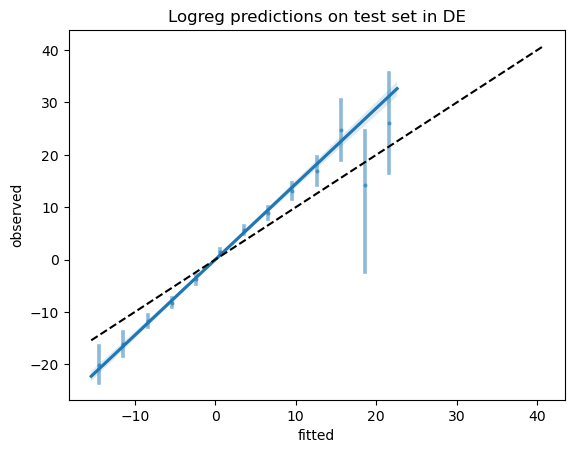

In [56]:
plot_fitted_observed(test_for_regression, 'Logreg predictions on test set in DE')

In [25]:
import torch.nn as nn
import torch

In [40]:
loss_func = nn.NLLLoss()
output = torch.swapaxes(torch.stack([torch.Tensor(test['fitted']), torch.Tensor(1 - test['fitted'])]), 0, 1)
loss_func(output, torch.Tensor(test['observed']).long()).item()

-0.04668327048420906

In [39]:
output.shape

torch.Size([2, 262422])

In [15]:
test_for_regression

fitted  observed
Stations_id year                    
7521.0      2018.0    98.0      95.0
            2019.0   107.0     105.0
            2020.0   113.0     107.0
            2022.0   110.0      99.0
7608.0      2019.0   102.0     102.0
...                    ...       ...
19585.0     2020.0   108.0     103.0
            2022.0   105.0     102.0
19700.0     2018.0    94.0     101.0
            2019.0   100.0     112.0
            2020.0   107.0     123.0

[1434 rows x 2 columns]

NameError: name 'comparison_frame' is not defined

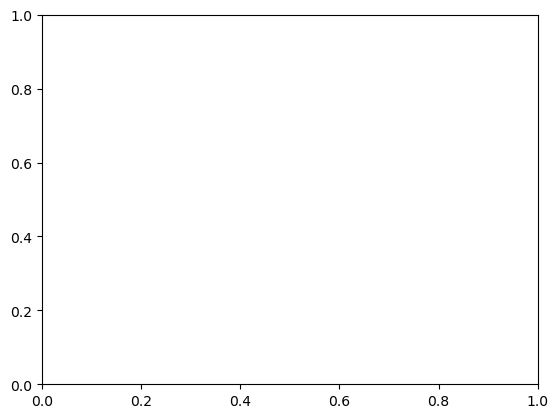

In [20]:
test_for_SSA, Xtest = compare_logreg_test(ds_panel_SSA.reset_index(), log_reg)

R2 score 0.05587869830011427


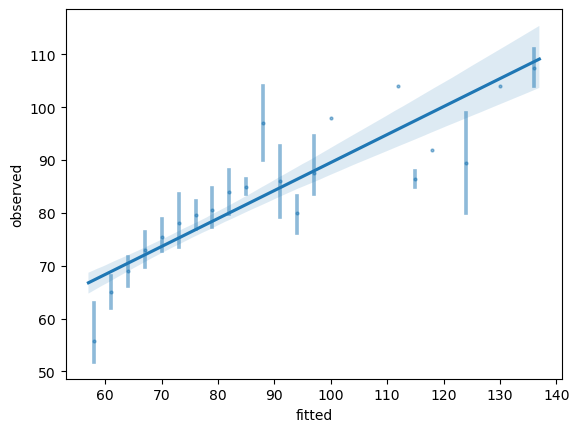

In [33]:
plot_fitted_observed(test_for_SSA)

In [20]:
(test_for_SSA['fitted'] - test_for_SSA['observed']).min()

-62.0

In [199]:
plot_fitted_observed(test_for_SSA)

ValueError: attempt to get argmin of an empty sequence

In [174]:
Xtest = test[['NDVI', 'acc temp', 'photoperiod', 'const']]
ytest = test[['dev stage']]
    
yhat = log_reg.predict(Xtest)
prediction = list(map(round, yhat))

# comparing original and predicted values of y
print('Actual values', list(ytest.values.squeeze()))
print('Predictions :', prediction)

Actual values [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

In [175]:
with warnings.catch_warnings(action="ignore"):
    Xtest.loc[:, 'fitted'] = log_reg.predict(Xtest).round()
    Xtest.loc[:, 'observed'] = ytest

In [46]:
Xtrain = ds_panel_DE[['NDVI', 'acc temp', 'photoperiod']]
ytrain = ds_panel_DE[['dev stage']]
 
# building the model and fitting the data
log_reg = sm.Logit(ytrain, Xtrain).fit()

Optimization terminated successfully.
         Current function value: 0.088185
         Iterations 10
